# Installing everything needed 

I keep on having an issue with this stage, and I am worried about it for running the model etc. 

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import bertopic

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired  # Correct import

from umap import UMAP
from hdbscan import HDBSCAN
import pycountry

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

import time


## 1. Creating CSV

Breaking on every line has had some issues so I will use breaking on every sentence instead. 

In [12]:
root_folder_path = '/Users/student/Desktop/LSE /Year 2/Capstone/NLP Week 11/Sharing with Juan/UN_Speeches'


def parse_filename(filename):
    name_parts = filename.replace('.txt', '').split('_')
    country = name_parts[0]
    session = name_parts[1]
    year = int(name_parts[2])
    return country, session, year

def preprocess_text(text):
    # Temporarily replace dots in common abbreviations with placeholders
    abbreviation_patterns = [
        r'\bMs\.', r'\bMr\.', r'\bDr\.', r'\bPresident\.'
    ]
    for pattern in abbreviation_patterns:
        text = re.sub(pattern, lambda match: match.group(0).replace('.', '[DOT]'), text)
    return text

def postprocess_sentence(sentence):
    # Replace placeholders back with proper dots
    return sentence.replace('[DOT]', '.')

sentence_data = []

for subfolder in os.listdir(root_folder_path):
    subfolder_path = os.path.join(root_folder_path, subfolder)
    
    if os.path.isdir(subfolder_path) and "Session" in subfolder:
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.txt'):
                country, session, year = parse_filename(filename)
                file_path = os.path.join(subfolder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    text_content = file.read()
                
                # Preprocess text
                text_content = preprocess_text(text_content)
                
                # Replace line breaks with a space
                text_content = text_content.replace('\n', ' ')
                
                # Split by full stops while ignoring placeholders for abbreviations
                sentences = re.split(r'(?<!\[DOT])\.\s+', text_content)
                
                for sentence in sentences:
                    sentence = sentence.strip()
                    if sentence: 
                        sentence_data.append([country, session, year, postprocess_sentence(sentence)])


sentence_df = pd.DataFrame(sentence_data, columns=['Country', 'Session', 'Year', 'Sentence'])

sentence_df.to_csv('un_speeches_split_by_sentence.csv', index=False)

country_code_to_name = {country.alpha_3: country.name for country in pycountry.countries}

sentence_df['Country Name'] = sentence_df['Country'].map(country_code_to_name)



Checking what the df looks like - it seems to have worked well. Splitting on sentences seems to be more robust than splitting on paragraphs. 

In [14]:
sentence_df.to_csv('/Users/student/Desktop/LSE /Year 2/Capstone/NLP Week 11/Sharing with Juan/correct_sentence_df.csv',index = False)

In [2]:
sentence_df = pd.read_csv("correct_sentence_df.csv")

In [3]:
sentence_df.head()

,Country,Session,Year,Sentence,Country Name
0,BRB,73,2018,Let me begin by congratulating Ms. María Ferna...,Barbados
1,BRB,73,2018,"However, I would like to pause at this stage, ...",Barbados
2,BRB,73,2018,Those events include the transit of a tropical...,Barbados
3,BRB,73,2018,Those events are of great concern because the ...,Barbados
4,BRB,73,2018,"I ask myself, what does all that matter? Last ...",Barbados


## 2. 1 Training the BERT model

The main part with this is we would like to be able to keep the BERT model afterwards and save it so it can be reloaded. This is the part that I am struggling with. 

#### Training the BERT model with one-shot embedding
This means that we can train Bert with predefined topics that we are interested in - I have created a list of topics that we care about from before 

In [4]:
zeroshot_topic_list = [
    "AI and Machine Learning",
    "Quantum Technology",
    "Semiconductors",
    "Data Management",
    "Biological Engineering",
    "Finacial Technology ",
    "Health Technology",
    "Smart Cities",
    "Cloud Computing",
    "General Emerging Technology",
    "Atomic Energy",
    "Energy Security",
    "Zero Carbon Energy",
    "Peaceful Development of Technology",
    "Digital Divide and Technology Transfer",
    "Technology capacity building",
    "Nuclear Weapons",
    "Military Technology",
    "Taiwan and Technology",
    "Biological Warfare",
    "Chemical Weapons",
    "Data Security and Cybercrime",
    "Election Interference",
    "Technological Surveillance"
]



In [69]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Extract sentences (assuming 'sentence_docs' is a list of sentences)
sentence_docs = sentence_df["Sentence"].tolist()

# Generate embeddings for the sentences
sentence_embeddings = embedding_model.encode(sentence_docs, show_progress_bar=True)


Batches:   0%|          | 0/11718 [00:00<?, ?it/s]

In [ ]:
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2", 
    min_topic_size=15,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.5,
    representation_model=KeyBERTInspired()
)
topics, _ = topic_model.fit_transform(sentence_docs, )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [64]:
sentence_df['Topic'] = topics

In [71]:
# Assuming `sentence_embeddings` is a 2D numpy array with shape (374959, 384)
sentence_df['Embedding'] = [embedding for embedding in sentence_embeddings]


In [9]:
topic_info = topic_model.get_topic_info()
topic_info.sho

,Topic,Count,Name,Representation,Representative_Docs
0,-1,164405,-1_nations_peace_conflicts_united,"[nations, peace, conflicts, united, israel, pa...","[Whether we wish it or not, we are being unit..."
1,0,5,AI and Machine Learning,"[ai, intelligence, models, artificial, product...","[AI can and should be a tool for all, The AI m..."
2,1,5,Quantum Technology,"[quantum, advances, technologies, technology, ...",[It is only through such a new partnership tha...
3,2,1,Data Management,"[data, critical, management, proper, that, the...",[The proper management of that data is critical]
4,3,3,Biological Engineering,"[biotechnology, cloning, genetic, engineering,...",[We are concerned by the recent developments i...
5,4,2,Finacial Technology,"[banking, financial, institutions, innovative,...",[One area where we could find solutions within...
6,5,67,Health Technology,"[health, technology, technological, technologi...",[There can be no doubt that for some informati...
7,6,6,Smart Cities,"[cities, urban, city, towns, villages, smart, ...",[Azerbaijan is building new cities and towns f...
8,7,77,General Emerging Technology,"[technologies, technology, technological, inno...","[On the one hand, new technologies are emergin..."
9,8,13,Atomic Energy,"[atomic, atom, nuclear, uranium, energy, inter...",[The International Atomic Energy Agency is an ...


In [30]:
topic_info.shape

(1599, 5)

### 2.2 Save the model

In [10]:
topic_model.save("bertopic_model", save_embedding_model=True)

2025-02-07 11:12:05,939 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


### 2.3 Load the pre-saved model 

In [62]:

topic_model = BERTopic.load("bertopic_model")


## 3.1 Visualisation of topics - Seeing top words in the Zeroshot topics 
###  Rename the topics so that they are represented correctly in the various visualisations 

In [11]:
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")

In [15]:
zeroshot_topic_dict = {
    0: "AI and Machine Learning",
    1: "Quantum Technology",
    2: "Data Management",
    3: "Biological Engineering",
    4: "Financial Technology",
    5: "Health Technology",
    6: "Smart Cities",
    7: "General Emerging Technology",
    8: "Atomic Energy",
    9: "Energy Security",
    10: "Zero Carbon Energy",
    11: "Peaceful Development of Technology",
    12: "Digital Divide and Technology Transfer",
    13: "Technology Capacity Building",
    14: "Nuclear Weapons",
    15: "Military Technology",
    16: "Taiwan and Technology",
    17: "Biological Warfare",
    18: "Chemical Weapons",
    19: "Data Security and Cybercrime",
    20: "Election Interference",
    21: "Technological Surveillance"
}

topic_model.set_topic_labels(zeroshot_topic_dict) 

In [16]:

zeroshot_topic_ids = topic_info[topic_info["Name"].isin(zeroshot_topic_list)]["Topic"].tolist()

## Barchart - showing if topics seem correct 

In [17]:
topic_model.visualize_barchart(topics=zeroshot_topic_ids, custom_labels = True )


## Visualise intertopic distance for zeroshot-topics 

In [19]:
import json

# Generate interactive visualisation
fig = topic_model.visualize_topics(topics=zeroshot_topic_ids)

# Convert the figure to JSON
fig_json = fig.to_json()

# Save as a JSON file
with open("bertopic_visualization.json", "w") as f:
    json.dump(fig_json, f)

In [21]:
topic_model.visualize_topics(topics=zeroshot_topic_ids, custom_labels = True)


## Visualise connections between topics 

In [23]:
topic_model.visualize_hierarchy(topics = zeroshot_topic_ids, custom_labels = True)

## Heatmap to visualise similarity between topics 

In [24]:
topic_model.visualize_heatmap(topics = zeroshot_topic_ids, custom_labels = True)

## Visualise the topics over time

In [31]:
topics_over_time = topic_model.topics_over_time(sentence_df['Sentence'], 
                                                sentence_df['Year'],  # Use the existing year column
                                                global_tuning=True, 
                                                evolution_tuning=True,
                                                nr_bins=len(sentence_df['Year'].unique()))  # One bin per year


In [32]:
# Filter the topics_over_time to only include the zero-shot topics
topics_over_time_zeroshot = topics_over_time[topics_over_time['Topic'].isin(zeroshot_topic_ids)]


In [33]:
# Visualize topics over time for the filtered zero-shot topics
topic_model.visualize_topics_over_time(topics_over_time_zeroshot)


In [43]:
fig = topic_model.visualize_topics_over_time(topics_over_time_zeroshot)

# Save the plot as a JSON file
fig.write_json("topics_over_time_zeroshot.json")

## 4.1 Country Visualisation 
Need to cluster the topics into larger groups and then we can visualise for countries in 4 year sections 


In [72]:
sentence_df

,Country,Session,Year,Sentence,Country Name,Group,YearPeriod,Topic,Embedding
0,BRB,73,2018,Let me begin by congratulating Ms. María Ferna...,Barbados,Other,2016,67,"[-0.036270916, -0.0026696608, 0.0026795529, -0..."
1,BRB,73,2018,"However, I would like to pause at this stage, ...",Barbados,Other,2016,-1,"[0.015536962, 0.029011553, 0.023046829, -0.011..."
2,BRB,73,2018,Those events include the transit of a tropical...,Barbados,Other,2016,-1,"[0.067203976, 0.04081179, 0.11460312, 0.070455..."
3,BRB,73,2018,Those events are of great concern because the ...,Barbados,Other,2016,-1,"[0.060707532, 0.074981414, 0.02815113, 0.03468..."
4,BRB,73,2018,"I ask myself, what does all that matter? Last ...",Barbados,Other,2016,891,"[0.09178345, 0.048956443, 0.018212734, 0.02262..."
...,...,...,...,...,...,...,...,...,...
374954,HUN,69,2014,"We have to heed the advice of Nicholas Stern, ...",Hungary,Other,2012,932,"[0.056570105, 0.06454281, 0.05719191, 0.002399..."
374955,HUN,69,2014,I have just cited the example of New York City,Hungary,Other,2012,1310,"[0.12445413, -0.03829655, 0.053601425, 0.03928..."
374956,HUN,69,2014,A few hundred million dollars would have been ...,Hungary,Other,2012,-1,"[0.014341723, 0.11719479, 0.060230006, -0.0165..."
374957,HUN,69,2014,The New York example tells us that we are not ...,Hungary,Other,2012,-1,"[0.10041228, 0.006510497, 0.10341268, 0.040018..."


In [87]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Assuming sentence_df has columns 'Sentence', 'Year', 'Topic', 'Country Name', and 'Embedding'

# Function to assign 3-year periods based on the 'Year'
def assign_3_year_period(year):
    start_year = (year // 3) * 3  # This will get the start year of the 3-year period
    return f"{start_year}-{start_year + 2}"

# Add the 3-year period column to the sentence_df
sentence_df['3_year_period'] = sentence_df['Year'].apply(assign_3_year_period)

# Filter the sentences that belong to each group
military_df = sentence_df[sentence_df['Group'] == 'Military Technology']
dual_use_df = sentence_df[sentence_df['Group'] == 'Dual-use Technology and Energy Security']
civilian_df = sentence_df[sentence_df['Group'] == 'Civilian Technology']
capacity_building_df = sentence_df[sentence_df['Group'] == 'Capacity Building']

# Function to aggregate by 3-year period and country, and calculate mean embeddings
def aggregate_embeddings(df):
    return df.groupby(['3_year_period', 'Country Name'], as_index=False).agg({
        'Embedding': lambda x: np.mean(np.array([emb for emb in x]), axis=0)  # Aggregate embeddings by taking the mean
    })

# Aggregate data for each group
aggregated_military_df = aggregate_embeddings(military_df)
aggregated_dual_use_df = aggregate_embeddings(dual_use_df)
aggregated_civilian_df = aggregate_embeddings(civilian_df)
aggregated_capacity_building_df = aggregate_embeddings(capacity_building_df)

# Apply K-means clustering to the aggregated data (5 clusters)
def apply_kmeans(df, n_clusters=5):
    embeddings = np.array([np.array(emb) for emb in df['Embedding']])
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    
    # Add the cluster labels to the dataframe
    df['Cluster'] = kmeans.labels_
    return df

# Apply K-means clustering to each group
aggregated_military_df = apply_kmeans(aggregated_military_df)
aggregated_dual_use_df = apply_kmeans(aggregated_dual_use_df)
aggregated_civilian_df = apply_kmeans(aggregated_civilian_df)
aggregated_capacity_building_df = apply_kmeans(aggregated_capacity_building_df)

# Perform PCA on the aggregated embeddings for each group
def perform_pca(df, n_components=2):
    embeddings = np.array([np.array(emb) for emb in df['Embedding']])

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Add PCA components to the dataframe
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]
    
    return df

# Apply PCA to each group
aggregated_military_df = perform_pca(aggregated_military_df)
aggregated_dual_use_df = perform_pca(aggregated_dual_use_df)
aggregated_civilian_df = perform_pca(aggregated_civilian_df)
aggregated_capacity_building_df = perform_pca(aggregated_capacity_building_df)

# Plot the PCA results with cluster labels
def plot_pca_with_clusters(df, title="PCA with K-means Clusters"):
    fig = px.scatter(df, x="PCA1", y="PCA2", text="Country Name", color="Cluster",
                     title=title, labels={"PCA1": "PCA Component 1", "PCA2": "PCA Component 2"})
    fig.update_traces(textposition="top center")
    fig.show()

# Plot PCA for each 3-year period with clustering results for each group
def plot_group_pca(aggregated_df, group_name):
    for period in aggregated_df['3_year_period'].unique():
        period_df = aggregated_df[aggregated_df['3_year_period'] == period]
        plot_pca_with_clusters(period_df, title=f"PCA for {group_name} (K-means Clusters): {period}")

# Plot for each group
plot_group_pca(aggregated_military_df, "Military Technology")
plot_group_pca(aggregated_dual_use_df, "Dual-use Technology and Energy Security")
plot_group_pca(aggregated_civilian_df, "Civilian Technology")
plot_group_pca(aggregated_capacity_building_df, "Capacity Building")


# Function to save PCA plots as JSON files
def save_pca_plot_as_json(df, group_name, period):
    # Create the directory if it doesn't exist
    folder_path = f"Country visualisations/{group_name}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Plot the PCA
    fig = px.scatter(df, x="PCA1", y="PCA2", text="Country Name", color="Cluster",
                     title=f"PCA for {group_name} (K-means Clusters): {period}",
                     labels={"PCA1": "PCA Component 1", "PCA2": "PCA Component 2"})
    fig.update_traces(textposition="top center")
    
    # Save the figure as a JSON file
    json_filename = f"{folder_path}/{period}_{group_name}_pca.json"
    fig.write_json(json_filename)

# Function to save all PCA plots for each group
def save_group_pca(aggregated_df, group_name):
    for period in aggregated_df['3_year_period'].unique():
        period_df = aggregated_df[aggregated_df['3_year_period'] == period]
        save_pca_plot_as_json(period_df, group_name, period)

# Save the visualisations for each group
save_group_pca(aggregated_military_df, "Military Technology")
save_group_pca(aggregated_dual_use_df, "Dual-use Technology and Energy Security")
save_group_pca(aggregated_civilian_df, "Civilian Technology")
save_group_pca(aggregated_capacity_building_df, "Capacity Building")



In [85]:

from sklearn.cluster import KMeans


# Assuming 'sentence_df' has columns 'Sentence', 'Year', 'Topic', 'Country Name', and 'Embedding'

# Function to assign 3-year periods based on the 'Year'
def assign_3_year_period(year):
    start_year = (year // 3) * 3  # This will get the start year of the 3-year period
    return f"{start_year}-{start_year + 2}"

# Add the 3-year period column to the sentence_df
sentence_df['3_year_period'] = sentence_df['Year'].apply(assign_3_year_period)

# Filter the sentences that are in the 'Military Technology' group
military_df = sentence_df[sentence_df['Group'] == 'Military Technology']

# Now, aggregate by 3-year period and country
aggregated_military_df = military_df.groupby(['3_year_period', 'Country Name'], as_index=False).agg({
    'Embedding': lambda x: np.mean(np.array([emb for emb in x]), axis=0)  # Aggregate embeddings by taking the mean
})

# 1. Apply K-means clustering (5 clusters)
def apply_kmeans(df, n_clusters=5):
    embeddings = np.array([np.array(emb) for emb in df['Embedding']])
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    
    # Add the cluster labels to the dataframe
    df['Cluster'] = kmeans.labels_
    return df

# Apply K-means to the aggregated data
aggregated_military_df = apply_kmeans(aggregated_military_df)

# 2. Perform PCA on the aggregated embeddings
def perform_pca(df, n_components=2):
    embeddings = np.array([np.array(emb) for emb in df['Embedding']])

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Add PCA components to the dataframe
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]
    
    return df

# Apply PCA to the aggregated data
aggregated_military_df = perform_pca(aggregated_military_df)

# 3. Plot the PCA results with cluster labels
def plot_pca_with_clusters(df, title="PCA with K-means Clusters"):
    fig = px.scatter(df, x="PCA1", y="PCA2", text="Country Name", color="Cluster",
                     title=title, labels={"PCA1": "PCA Component 1", "PCA2": "PCA Component 2"})
    fig.update_traces(textposition="top center")
    fig.show()

# Plot PCA for each 3-year period with clustering results
for period in aggregated_military_df['3_year_period'].unique():
    period_df = aggregated_military_df[aggregated_military_df['3_year_period'] == period]
    plot_pca_with_clusters(period_df, title=f"PCA for Military Technology (K-means Clusters): {period}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/student/anaconda3/envs/Capstone/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




In [88]:
military_technology_df.shape

NameError: name 'military_technology_df' is not defined

In [81]:
capacity_building_df.shape

(268, 10)

## Clustering the embeddings and then seeing how the countries clustered together over time 

In [44]:
# Get the indices of sentences that belong to the zero-shot topics
zero_shot_indices = [i for i, topic in enumerate(topics) if topic in zeroshot_topic_ids]

# Extract embeddings for these sentences
zero_shot_embeddings = sentence_embeddings[zero_shot_indices]

# Extract corresponding sentences and countries
zero_shot_sentences = [sentence_docs[i] for i in zero_shot_indices]
zero_shot_countries = [df['country'][i] for i in zero_shot_indices]  # Assuming 'country' column exists


NameError: name 'sentence_embeddings' is not defined

In [ ]:
# Get the indices of sentences that belong to the zero-shot topics
zero_shot_indices = [i for i, topic in enumerate(topics) if topic in zeroshot_topic_ids]

# Extract embeddings for these sentences
zero_shot_embeddings = sentence_embeddings[zero_shot_indices]

# Extract corresponding sentences and countries
zero_shot_sentences = [sentence_docs[i] for i in zero_shot_indices]
zero_shot_countries = [df['country'][i] for i in zero_shot_indices]  # Assuming 'country' column exists


In [ ]:
# Compute the average cluster label per country in each 3-year period
aggregated_data = df_clustered.groupby(['country', 'period', 'cluster']).size().reset_index(name='count')

# You can then calculate a measure of similarity, for example, the number of common clusters between countries.


In [ ]:
# Aggregate embeddings by country and period
agg_embeddings = df_clustered.groupby(['country', 'period']).agg({'embedding': 'mean'}).reset_index()

# Calculate cosine similarity between countries' aggregated embeddings for each period
similarity_matrix = cosine_similarity(list(agg_embeddings['embedding']))

# Visualize the similarity matrix for each 3-year period
import seaborn as sns
import matplotlib.pyplot as plt

for period in agg_embeddings['period'].unique():
    # Extract the countries and their embeddings for this period
    countries_in_period = agg_embeddings[agg_embeddings['period'] == period]
    similarity_matrix_period = similarity_matrix[:len(countries_in_period), :len(countries_in_period)]

    # Plot the similarity matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix_period, xticklabels=countries_in_period['country'], 
                yticklabels=countries_in_period['country'], cmap='coolwarm', annot=True)
    plt.title(f"Country Similarity for Period {period}-{period+3}")
    plt.show()


In [ ]:
# Apply DBSCAN clustering to the zero-shot sentence embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(zero_shot_embeddings)

# Add the cluster labels to the DataFrame
df_clustered['cluster'] = dbscan_labels


In [ ]:
import umap

# Apply UMAP to reduce the dimensionality of the embeddings
umap_model = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(zero_shot_embeddings)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe with UMAP embeddings and cluster labels
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
umap_df['cluster'] = dbscan_labels
umap_df['country'] = df_clustered['country']  # Add country column for labelling

# Plot the results
plt.figure(figsize=(12, 10))

# Create a scatter plot coloured by DBSCAN clusters
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=100, alpha=0.7, marker='o')

# Annotate with country labels
for i in range(umap_df.shape[0]):
    plt.text(umap_df['UMAP1'].iloc[i], umap_df['UMAP2'].iloc[i], umap_df['country'].iloc[i], 
             fontsize=9, alpha=0.8)

# Add titles and labels
plt.title("DBSCAN Clusters of Countries Based on Zero-Shot Topics", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="DBSCAN Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


## Showing whether countries become more or less similar to the UK 

In [ ]:
# Convert year column into 3-year bins
df_clustered['year_bin'] = (df_clustered['year'] // 3) * 3

# Aggregate embeddings by country and 3-year period (taking the mean)
country_embeddings = df_clustered.groupby(['country', 'year_bin'])['embedding'].apply(np.mean).reset_index()


In [ ]:
# Convert year column into 3-year bins
df_clustered['year_bin'] = (df_clustered['year'] // 3) * 3

# Aggregate embeddings by country and 3-year period (taking the mean)
country_embeddings = df_clustered.groupby(['country', 'year_bin'])['embedding'].apply(np.mean).reset_index()


In [ ]:
]
# Convert year column into 3-year bins
df_clustered['year_bin'] = (df_clustered['year'] // 3) * 3

# Aggregate embeddings by country and 3-year period (taking the mean)
country_embeddings = df_clustered.groupby(['country', 'year_bin'])['embedding'].apply(np.mean).reset_index()


### Other coding option

In [8]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model)

In [9]:

sentence_docs = sentence_df['Sentence'].tolist()    

sentence_topics, sentence_probs = topic_model.fit_transform(sentence_docs)
sentence_df['Topic'] = sentence_topics
sentence_df['Probability'] = sentence_probs

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitl

In [13]:
sentence_df

,Country,Session,Year,Sentence,Country Name,Topic,Probability
0,BRB,73,2018,Let me begin by congratulating Ms. María Ferna...,Barbados,290,1.000000
1,BRB,73,2018,"However, I would like to pause at this stage, ...",Barbados,-1,0.000000
2,BRB,73,2018,Those events include the transit of a tropical...,Barbados,102,1.000000
3,BRB,73,2018,Those events are of great concern because the ...,Barbados,2167,1.000000
4,BRB,73,2018,"I ask myself, what does all that matter? Last ...",Barbados,102,1.000000
...,...,...,...,...,...,...,...
374954,HUN,69,2014,"We have to heed the advice of Nicholas Stern, ...",Hungary,84,1.000000
374955,HUN,69,2014,I have just cited the example of New York City,Hungary,496,0.334218
374956,HUN,69,2014,A few hundred million dollars would have been ...,Hungary,1815,1.000000
374957,HUN,69,2014,The New York example tells us that we are not ...,Hungary,-1,0.000000


## PCA Analysis 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


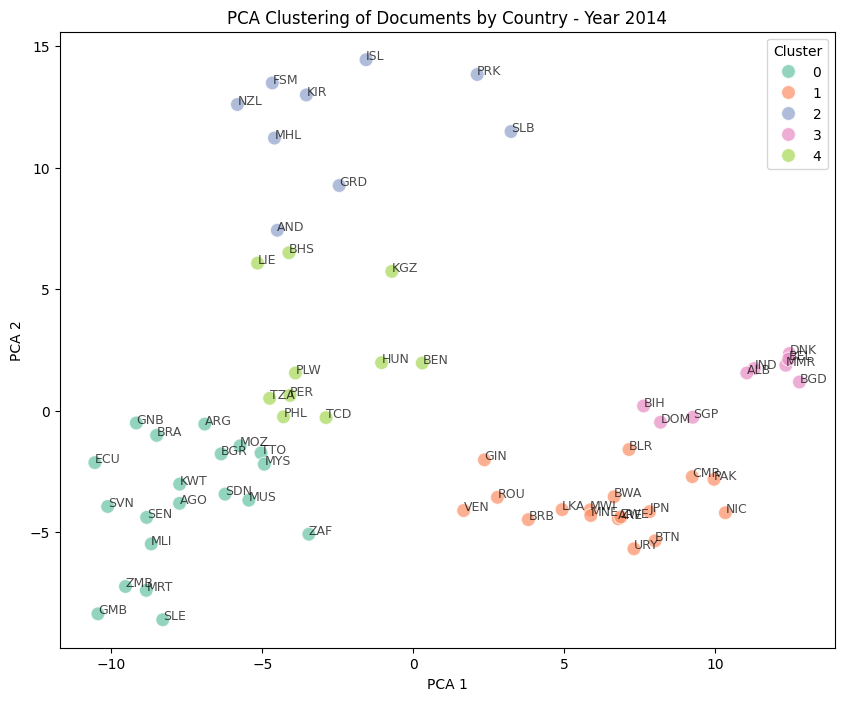

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

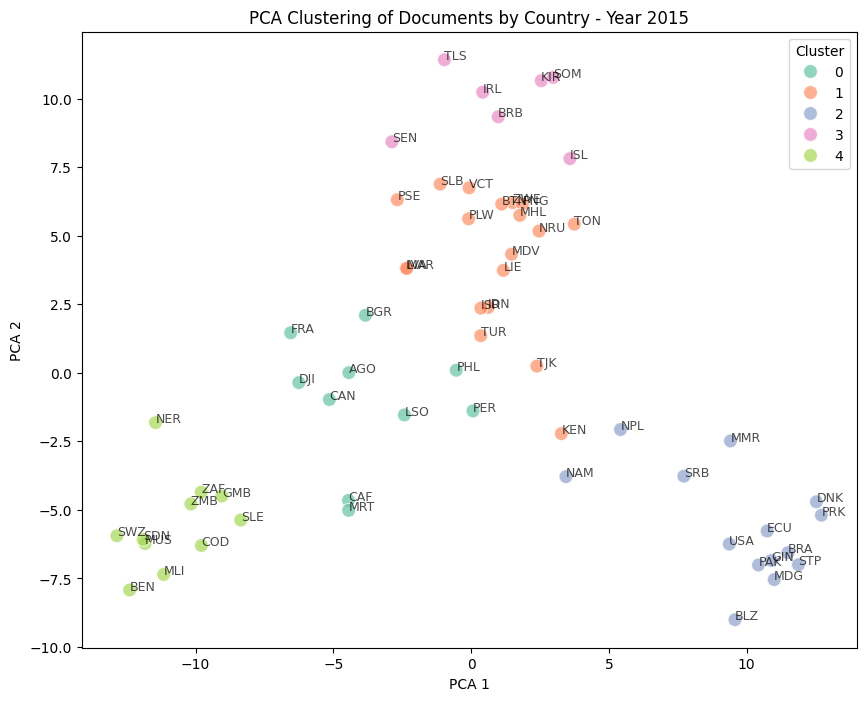

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

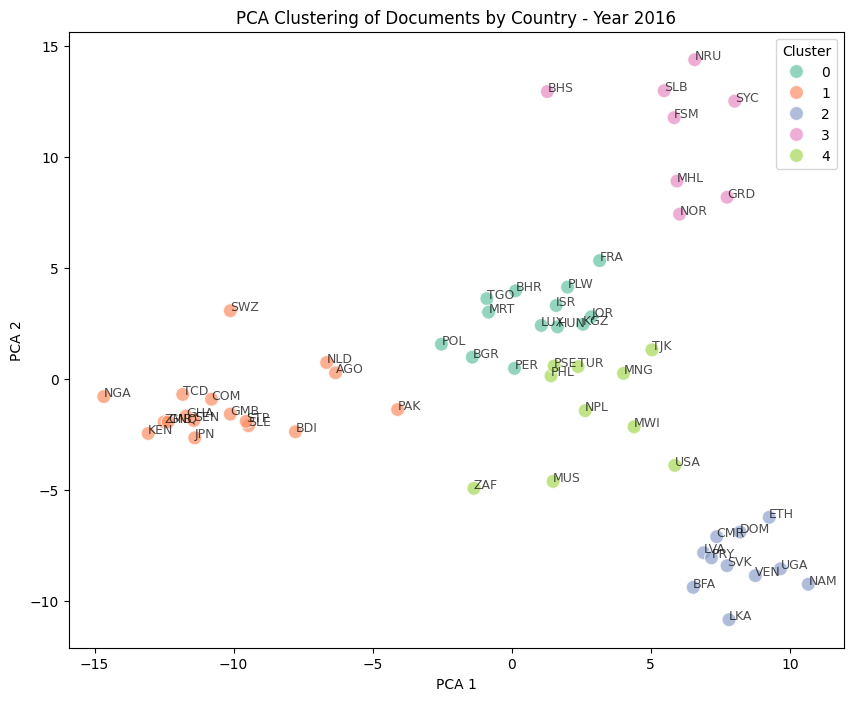

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

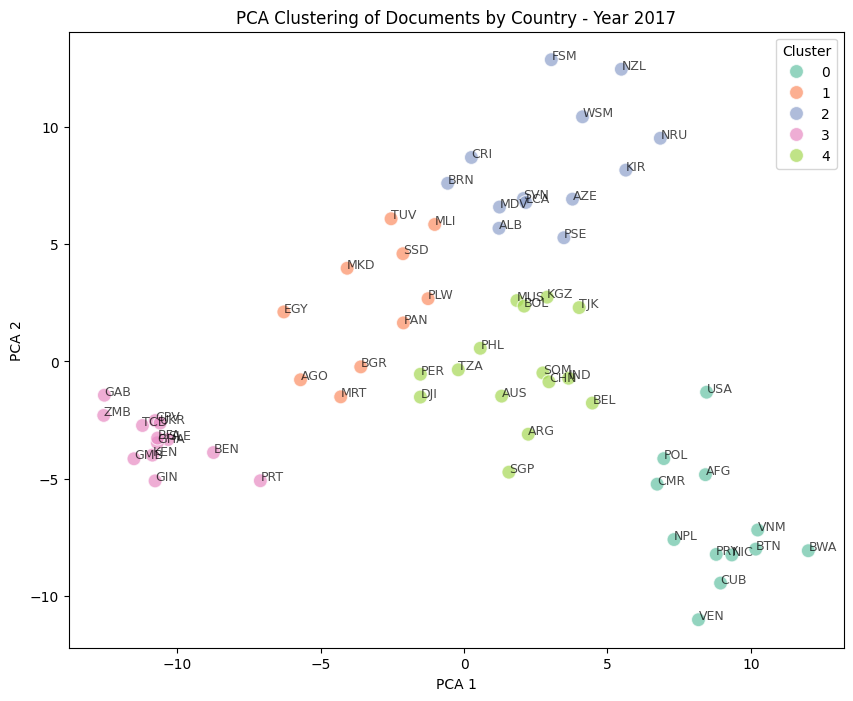

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

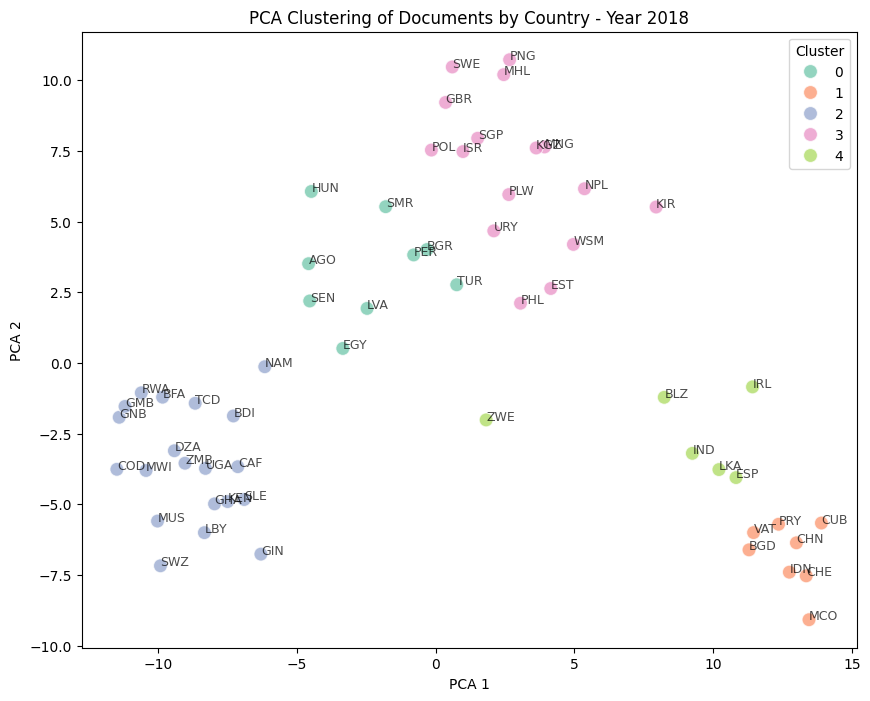

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

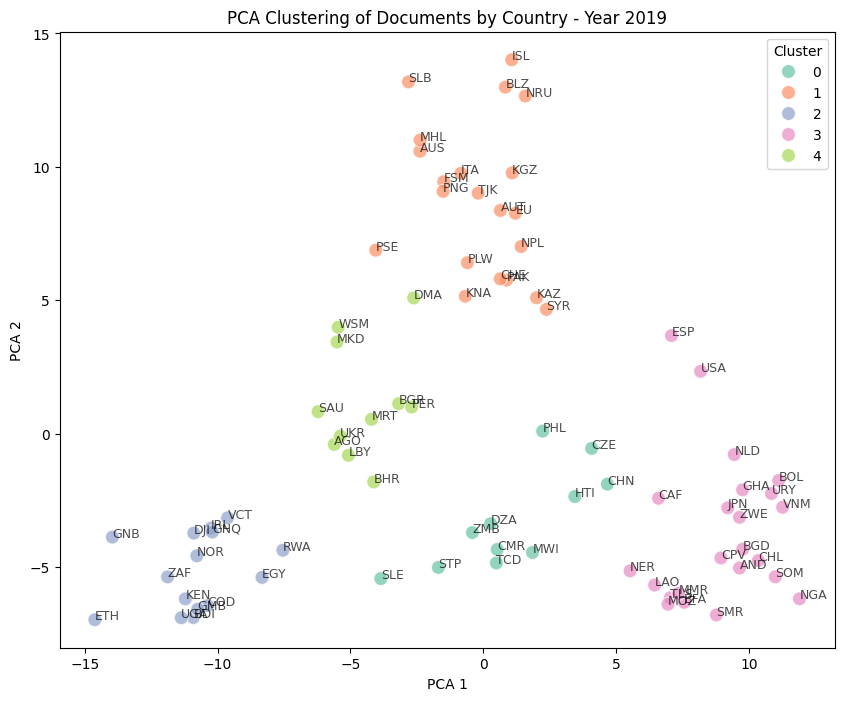

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

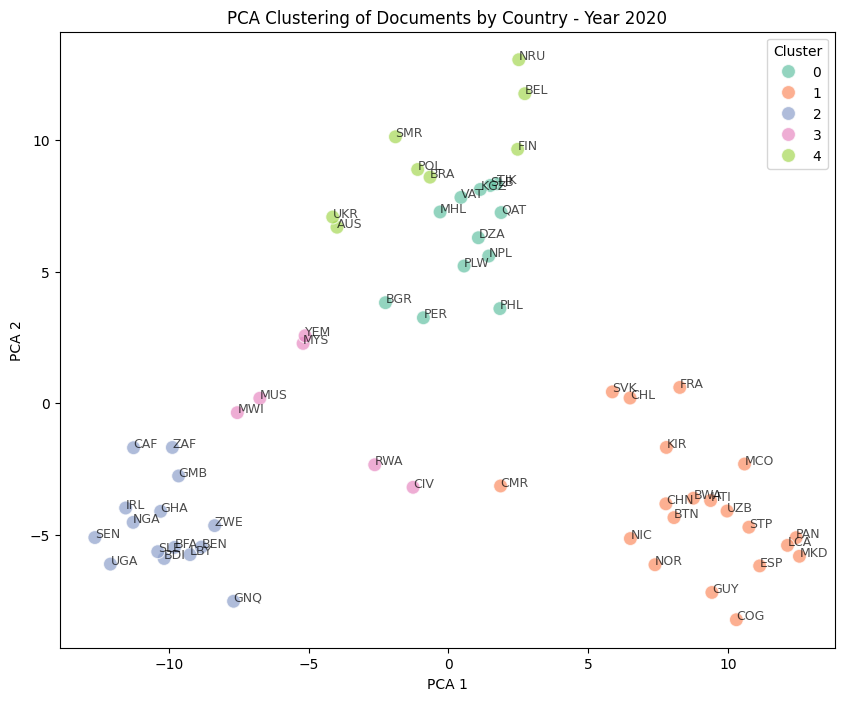

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

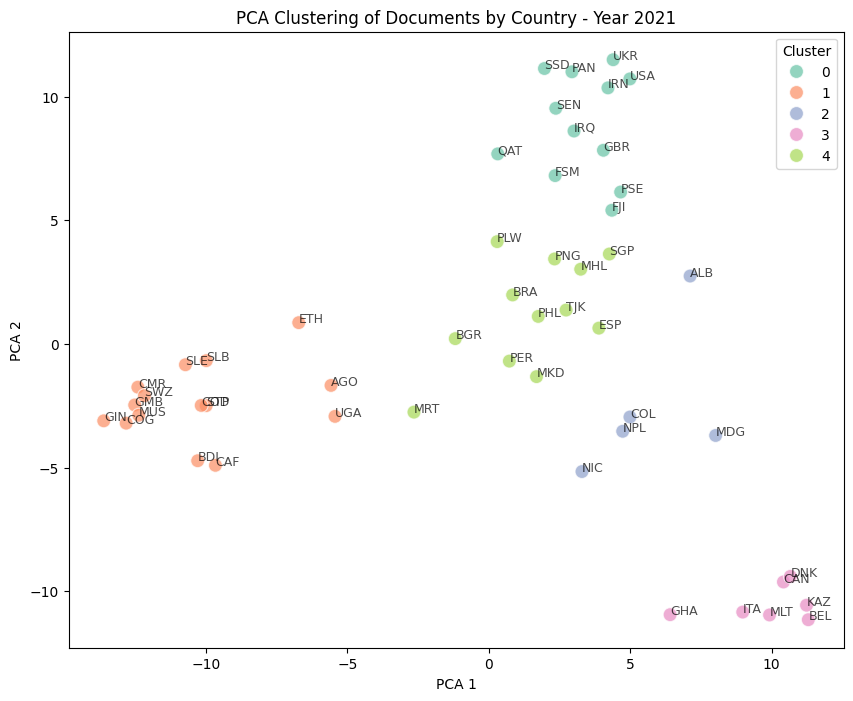

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

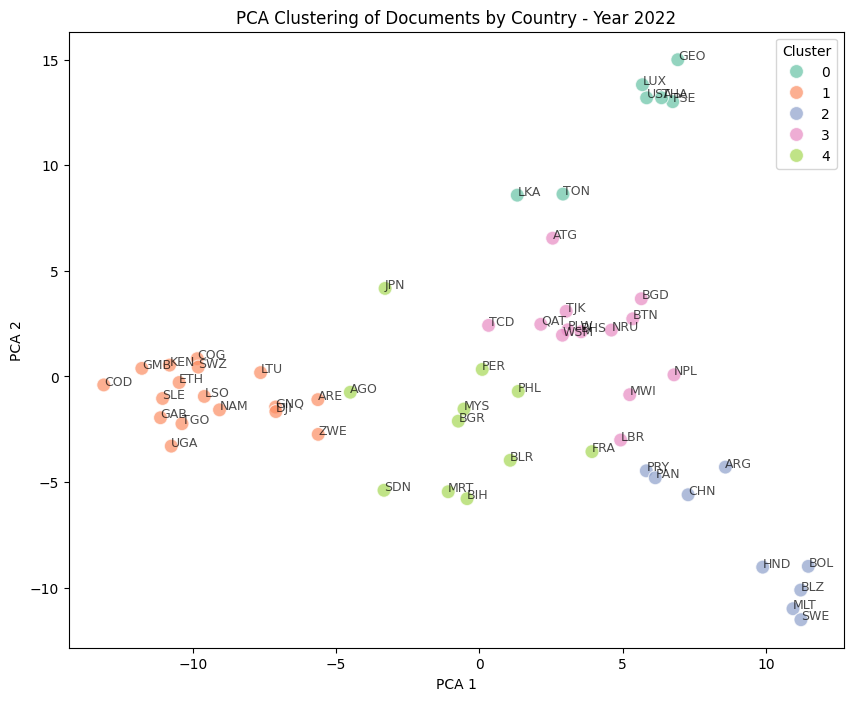

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

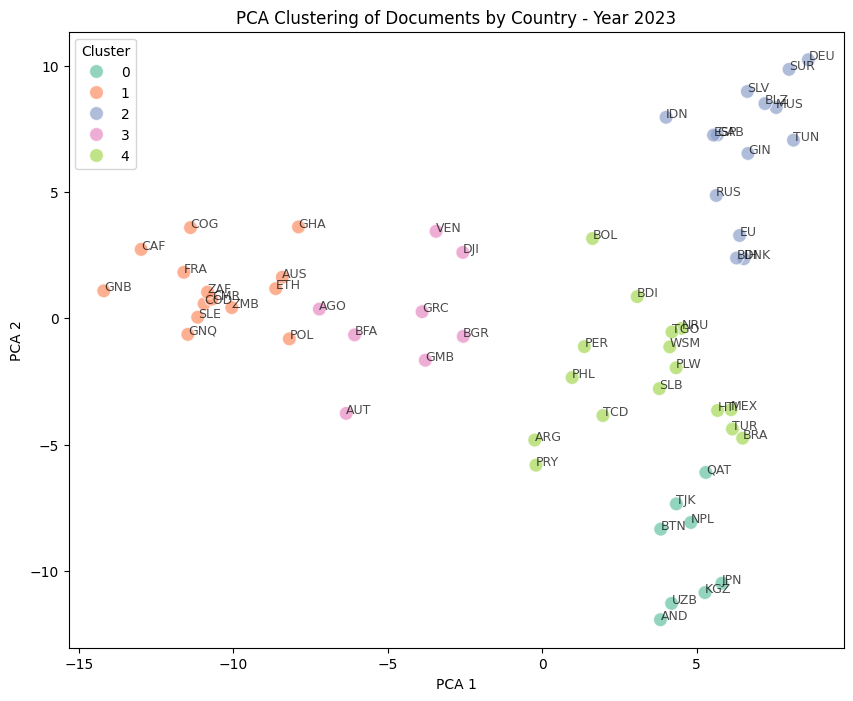

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

topic_ids = list(relevant_topics.keys())
filtered_sentences_df = sentence_df[sentence_df['Topic'].isin(topic_ids)]

# Step 2: Aggregate the embeddings for each country (one point per country)
# Group by country and aggregate embeddings by averaging

def aggregate_embeddings(df, embedding_model):
    country_embeddings = []
    countries = df['Country'].unique()
    
    for country in countries:
        country_data = df[df['Country'] == country]
        sentences = country_data['Sentence'].tolist()
        
        # Encode sentences and average the embeddings
        embeddings = embedding_model.encode(sentences, show_progress_bar=True)
        country_embedding = embeddings.mean(axis=0)  # Averaging the embeddings
        country_embeddings.append(country_embedding)
    
    return countries, country_embeddings

# Step 3: Loop through each year and create visualizations
years = range(2014, 2025)  # From 2014 to 2024

for year in years:
    # Filter the data for the specific year
    year_data = filtered_sentences_df[filtered_sentences_df['Year'] == year]
    
    if year_data.empty:
        continue  # Skip years with no data

    # Aggregate the embeddings for each country
    countries, country_embeddings = aggregate_embeddings(year_data, embedding_model)
    
    # Step 4: Standardize the embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(country_embeddings)

    # Step 5: Apply PCA
    pca = PCA(n_components=2)  # Reduce to 2 components for visualization
    pca_result = pca.fit_transform(embeddings_scaled)

    # Step 6: Perform KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)  # You can change the number of clusters
    clusters = kmeans.fit_predict(pca_result)

    # Step 7: Create a DataFrame for plotting
    pca_df = pd.DataFrame({
        'Country': countries,
        'PCA1': pca_result[:, 0],
        'PCA2': pca_result[:, 1],
        'Cluster': clusters
    })

    # Step 8: Plot the PCA results with clustering
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.7)

    # Add labels for each country
    for i in range(len(pca_df)):
        plt.text(
            pca_df['PCA1'].iloc[i], 
            pca_df['PCA2'].iloc[i], 
            pca_df['Country'].iloc[i], 
            fontsize=9, 
            alpha=0.7,
            color='black'
        )

    plt.title(f'PCA Clustering of Documents by Country - Year {year}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title='Cluster')
    plt.show()

    # Optionally, save the plot
    # plt.savefig(f'pca_clustering_year_{year}.png')
